In [21]:
import cv2
image = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/bg.jpeg')
bg = cv2.resize(image, (1800, 1800))
image = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/test.jpg')
image = cv2.cvtColor(image, cv2.IMREAD_COLOR)

In [7]:
import os
import keras_cv
import tensorflow as tf

# Class mapping
class_ids = [
    "10c",
    "10d",
    "10h",
    "10s",
    "2c",
    "2d",
    "2h",
    "2s",
    "3c",
    "3d",
    "3h",
    "3s",
    "4c",
    "4d",
    "4h",
    "4s",
    "5c",
    "5d",
    "5h",
    "5s",
    "6c",
    "6d",
    "6h",
    "6s",
    "7c",
    "7d",
    "7h",
    "7s",
    "8c",
    "8d",
    "8h",
    "8s",
    "9c",
    "9d",
    "9h",
    "9s",
    "Ac",
    "Ad",
    "Ah",
    "As",
    "Jc",
    "Jd",
    "Jh",
    "Js",
    "Kc",
    "Kd",
    "Kh",
    "Ks",
    "Qc",
    "Qd",
    "Qh",
    "Qs",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


def create_custom_model():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xl_backbone_coco")
    yolo = keras_cv.models.YOLOV8Detector(
        num_classes=len(class_mapping),
        bounding_box_format="center_xywh",
        backbone=backbone,
        fpn_depth=1,
    )
    return yolo


def load_model():
    reconstructed_yolo = create_custom_model()
    reconstructed_yolo.load_weights("/Users/sergi/code/seeergiii/blackjack/blackjack/inference/models__20230905-0551_model_weights.h5")
    return reconstructed_yolo


def cards_prediction(image, model):
    decoded_img = tf.io.decode_image(image, channels=3, dtype=tf.dtypes.uint8)
    resized_img = tf.image.resize(decoded_img, (416, 416))
    expanded_img = tf.expand_dims(resized_img, axis=0)
    casted_img = tf.cast(expanded_img, tf.float32)

    y_pred = model.predict(casted_img)

    return y_pred

In [8]:
import numpy as np
import cv2
import imutils
import tensorflow as tf

def map_coordinates_back(top_left_x, top_left_y, w, h, scale_factor, x_offset, y_offset, original_width, original_height, frame_width, frame_height):
    # Step 1: Model Prediction scaling
    scale_x = frame_width / 416
    scale_y = frame_height / 416
    top_left_x = int(top_left_x * scale_x)
    top_left_y = int(top_left_y * scale_y)
    w = int(w * scale_x)
    h = int(h * scale_y)

    # Step 2: Remove offset
    top_left_x -= x_offset
    top_left_y -= y_offset

    # Step 3: Scale back
    top_left_x = int(top_left_x / scale_factor)
    top_left_y = int(top_left_y / scale_factor)
    w = int(w / scale_factor)
    h = int(h / scale_factor)

    # Step 4: Map back to original dimensions
    resize_factor_x = original_width / 1000
    resize_factor_y = original_height / 1000
    top_left_x = int(top_left_x * resize_factor_x)
    top_left_y = int(top_left_y * resize_factor_y)
    w = int(w * resize_factor_x)
    h = int(h * resize_factor_y)

    return top_left_x, top_left_y, w, h

def place_contours_on_bg(image: np.ndarray, bg_image: np.ndarray, scale_factor=1.5):
    image_resized = imutils.resize(image, width=1000)
    image_greyscale = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    image_blurred = cv2.GaussianBlur(image_greyscale, (5, 5), 0)
    image_canny_kernel = cv2.Canny(image_blurred, 50, 150)
    contours, _ = cv2.findContours(image_canny_kernel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    modified_bgs = []

    for contour in contours:
        mask = np.zeros_like(image_resized)
        cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        contour_content = cv2.bitwise_and(image_resized, mask)

        # Create bounding box from contour to crop the alpha mask
        x, y, w, h = cv2.boundingRect(contour)
        alpha_mask = mask[y:y+h, x:x+w][:,:,0] 

        # Crop only the exact shape of the contour
        cropped_content = contour_content[y:y+h, x:x+w]

        # Scale both the cropped_content and the alpha mask
        scaled_content = cv2.resize(cropped_content, None, fx=scale_factor, fy=scale_factor)
        scaled_alpha = cv2.resize(alpha_mask, None, fx=scale_factor, fy=scale_factor)

        x_offset = (bg_image.shape[1] - scaled_content.shape[1]) // 2
        y_offset = (bg_image.shape[0] - scaled_content.shape[0]) // 2

        temp_bg = bg_image.copy()

        # Convert grayscale alpha mask to 3 channel
        alpha_color = cv2.merge([scaled_alpha, scaled_alpha, scaled_alpha])

        
        # Normalize the alpha mask
        alpha_normalized = alpha_color / 255.0

        # Place the scaled contour content
        temp_bg[y_offset:y_offset+scaled_content.shape[0], x_offset:x_offset+scaled_content.shape[1]] = \
            temp_bg[y_offset:y_offset+scaled_content.shape[0], x_offset:x_offset+scaled_content.shape[1]] * \
            (1 - alpha_normalized) + scaled_content * alpha_normalized

        modified_bgs.append(temp_bg)

    print("✅ placed contours on background images")

    return modified_bgs, scale_factor, x_offset, y_offset


example, scale_factor, x_offset, y_offset = place_contours_on_bg(image, bg, scale_factor=2)

#from inference.interface.yolo import load_model
model = load_model()

# Loop through each frame in example
for frame_cropped in example:
    # Recoding and decoding frame
    frame_recoded = cv2.imencode(".jpg", frame_cropped)[1].tobytes()
    decoded_img = tf.io.decode_image(frame_recoded, channels=3, dtype=tf.dtypes.uint8)
    
    # Preparing image for model prediction
    resized_img = tf.image.resize(decoded_img, (416, 416))
    expanded_img = tf.expand_dims(resized_img, axis=0)
    casted_img = tf.cast(expanded_img, tf.float32)
    
    # Predict using the model
    y_pred = model.predict(casted_img)

    # Retrieve dimensions for mapping coordinates back
    frame_height, frame_width = frame_cropped.shape[:2]
    original_height, original_width = image.shape[:2]

    # Process the detections
    num_detections = int(y_pred['num_detections'][0])  # Make sure it's an integer
    for index in range(num_detections):
        bbox = y_pred['boxes'][0][index]

        # Convert to integers
        center_x, center_y, w, h = map(int, bbox)
        top_left_x = center_x - (w // 2)
        top_left_y = center_y - (h // 2)

        # Map coordinates back to the original image
        top_left_x, top_left_y, w, h = map_coordinates_back(
            top_left_x, top_left_y, w, h,
            scale_factor, x_offset, y_offset,
            original_width, original_height,
            frame_width, frame_height
        )
        
        # Draw the rectangle on the original image
        cv2.rectangle(image, (top_left_x, top_left_y), (top_left_x + w, top_left_y + h), (0, 255, 0), 2)

✅ placed contours on background images
1/1 [==============================] - 1s 883ms/step


KeyboardInterrupt: 

In [189]:
#INVESTIGATION OF MAPPING BACK THE COORDINATES TO ORIGINAL IMAGE

In [43]:
import cv2
image = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/bg.jpeg')
bg = cv2.resize(image, (1800, 1800))
#image = cv2.imread('/Users/poloniki/code/sergi/git_blacl/blackjack/blackjack/inference/real.jpg')
image = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/test.jpg')

image = cv2.cvtColor(image, cv2.IMREAD_COLOR)

In [11]:
def calculate_new_coordinates(old_shape, new_shape):    
    old_height, old_width, _ = old_shape
    new_height, new_width, _ = new_shape
    return old_width / new_width, old_height / new_height

def get_old_coordinates_for_box(bbox, contour, input_shape:tuple, resized_shape:tuple, scaler:float=4.326):
    #Scale bbox back
    bbox = bbox * scaler
    
    # Convert to integers
    center_x, center_y, w_pred, h_pred  = map(int, bbox)
    
    # Convert center-xywh to top-left x,y
    top_left_x = center_x - (w_pred // 2)
    top_left_y = center_y - (h_pred // 2)
    print(top_left_x)
    
    # Coordinate of box inside of card
    x_mask, y_mask = (max(0,x_offset - top_left_x),max(0,y_offset-top_left_y)) 
    w_mask, h_mask = w_pred,h_pred
    print(f'x_mask:{x_mask}, y_mask {y_mask} w_mask {w_mask} h_mask {h_mask}' )
    
    # COORDINATES OF THE BLOCK OF CARDS ARE JUST COORDINATES OF THE CONTAINER
    x, y, w, h = cv2.boundingRect(contour)
    print('countour', x,y)
    
    # Coordinates of small box on resized image are
    x_small_box, y_small_box = x + x_mask, y+y_mask
    width_small_box, height_small_box = x_mask + (w_pred*2), y_mask + (h_pred*2)
    print('Small Box Coor', x_small_box, y_small_box,width_small_box, height_small_box)
    
    old_shape = input_shape

    # Shape of image after resizing to 1000 width (height, width, channels)
    new_shape = resized_shape
    new_coordinates = (x_small_box, y_small_box)

    # Calculate the old coordinates
    coef_x, coef_y = calculate_new_coordinates(old_shape, new_shape)
    old_coordinates = int(new_coordinates[0] *coef_x), int(new_coordinates[1]*coef_y)
    
    old_x, old_y = old_coordinates
    old_width = int(old_x+width_small_box*coef_x)
    old_height = int(old_y+height_small_box*coef_y)
    
    return old_x, old_y, old_width, old_height

def recreate_to_orig_rel(last_image, resized_img, contour,bbox,x_offset, y_offset):
    # Getting the coordinates of the cropped image inside of the resized image of Width 1000
    x, y, w, h = cv2.boundingRect(contour)
    
    
    
    # Convert to integers bbox - prediction of the model 
    center_x, center_y, w_pred, h_pred = map(int, bbox)
    # Convert center-xywh to top-left x,y
    top_left_x = center_x - (w_pred // 2) 
    top_left_y = center_y - (h_pred // 2)
    
    print('top_left_x', top_left_x,top_left_y)
    
    print((top_left_x - x_offset) / w)
    print((top_left_y - y_offset) / h)
    
    # 416 are the dimensions of the resized image for the model
    x_rel, w_rel = top_left_x / 416, (top_left_x + w_pred) / 416
    y_rel, h_rel = top_left_y / 416, ( top_left_y + h_pred) / 416
    
    # Getting shape of the cropped image  
    last_image_shape = last_image.shape

    # Getting the relative coordinate of the card box inside of the cropped image
    x_pr = int(x_rel*last_image_shape[1])
    y_pr = int(y_rel*last_image_shape[0])
    w_pr  = int(w_rel*last_image_shape[1])
    h_pr = int(h_rel*last_image_shape[1])
    
    print(x_pr,y_pr,w_pr,h_pr)
    
    print(resized_img.shape[1])

    # Recreation of the coordinates on the rezised image to Width of 1000
    x_100width = x / resized_img.shape[1]
    w_100width = w / resized_img.shape[1]

    y_100width = y/ resized_img.shape[0]
    h_100width = h/ resized_img.shape[0]

    # Recreation of the original cordinates
    final_x = int(x_100width*image.shape[1])
    final_w= int(w_100width*image.shape[1]) +final_x

    final_y = int(y_100width*image.shape[0])
    final_h = int(h_100width*image.shape[0]) +final_y
    
    return final_x, final_y, final_w, final_h

    

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import tensorflow as tf

def place_contours_on_bg(original_image: np.ndarray, bg_image: np.ndarray, scale_factor=1.5):
    image_resized = imutils.resize(original_image, height=1000, width=1000)
    image_greyscale = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    image_blurred = cv2.GaussianBlur(image_greyscale, (5, 5), 0)
    image_canny_kernel = cv2.Canny(image_blurred, 50, 150)
    contours, _ = cv2.findContours(image_canny_kernel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    modified_bgs = []

    preprocessed_image_size = image_canny_kernel.shape[0] * image_canny_kernel.shape[1]
    
    for contour in contours:
        mask = np.zeros_like(image_resized)
        cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        contour_content = cv2.bitwise_and(image_resized, mask)

        # Create bounding box from contour to crop the alpha mask
        x, y, w, h = cv2.boundingRect(contour)
        
        if ((w * h)/preprocessed_image_size) > 0.005 and w/h > 0.15 and h/w > 0.15:
            print(x, y, w, h)
            alpha_mask = mask[y:y+h, x:x+w][:,:,0] 

            # Crop only the exact shape of the contour
            cropped_content = contour_content[y:y+h, x:x+w]

            # Scale both the cropped_content and the alpha mask
            scaled_content = cv2.resize(cropped_content, None, fx=scale_factor, fy=scale_factor)
            scaled_alpha = cv2.resize(alpha_mask, None, fx=scale_factor, fy=scale_factor)

            x_offset = (bg_image.shape[1] - scaled_content.shape[1]) // 2
            y_offset = (bg_image.shape[0] - scaled_content.shape[0]) // 2

            temp_bg = bg_image.copy()

            # Convert grayscale alpha mask to 3 channel
            alpha_color = cv2.merge([scaled_alpha, scaled_alpha, scaled_alpha])

            
            # Normalize the alpha mask
            alpha_normalized = alpha_color / 255.0

            # Place the scaled contour content
            temp_bg[y_offset:y_offset+scaled_content.shape[0], x_offset:x_offset+scaled_content.shape[1]] = \
                temp_bg[y_offset:y_offset+scaled_content.shape[0], x_offset:x_offset+scaled_content.shape[1]] * \
                (1 - alpha_normalized) + scaled_content * alpha_normalized

            modified_bgs.append(temp_bg)

    print("✅ placed contours on background images")

     
    return modified_bgs, x, y, w, h, x_offset, y_offset, contours, image_resized


In [64]:
example, x_orig, y_orig, w_orig, h_orig, x_offset, y_offset, contours, image_resized_re = place_contours_on_bg(image, bg, scale_factor=2)

114 603 669 571
768 528 44 256
465 462 162 95
367 93 375 433
649 63 33 204
✅ placed contours on background images


1/1 [==============================] - 9s 9s/step
top_left_x 322 156
-136.25
-13.846153846153847
1393 675 1544 770
1000
top_left_x 59 273
-202.0
-10.846153846153847
255 1181 424 1285
1000
1/1 [==============================] - 1s 554ms/step


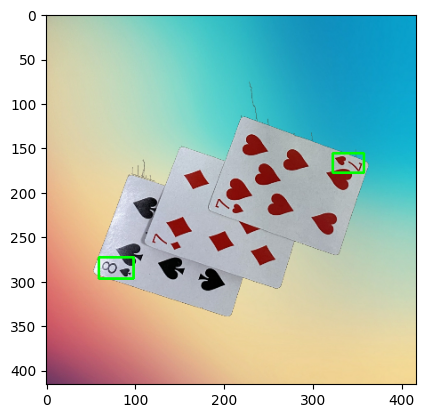

In [65]:
#from inference.interface.yolo import load_model
model = load_model()

countour_list = []
countour_index = 0

for index, frame_cropped in enumerate(example):
    
    frame_recoded = cv2.imencode(".jpg", frame_cropped)[1].tobytes()
    decoded_img = tf.io.decode_image(frame_recoded, channels=3, dtype=tf.dtypes.uint8)
    resized_img = tf.image.resize(decoded_img, (416, 416))
    expanded_img = tf.expand_dims(resized_img, axis=0)
    casted_img = tf.cast(expanded_img, tf.float32)
    y_pred = model.predict(casted_img)
    
    #Convert TF image to Cv2 Image
    recoded = casted_img[0].numpy()
    opencv_image = recoded.astype('uint8')
    num_detections = y_pred['num_detections'][0]

    boxes_in_countour_list = []
    
    for index in range(num_detections):
        bbox = y_pred['boxes'][0][index]
        countour = contours[countour_index]
        # x, y, w, h = cv2.boundingRect(countour)
        # print(x,y,w,h, 'countur')
        
        x_recreated, y_recreated, width_r, height_r = recreate_to_orig_rel(example[countour_index], image_resized_re, countour,bbox, x_offset, y_offset)
        boxes_in_countour_list.append([x_recreated, y_recreated, width_r, height_r])
        
        ########### PLOTTING THE RESULT OF THE MODEL
        # Convert to integers
        center_x, center_y, w_pred, h_pred = map(int, bbox)
        # Convert center-xywh to top-left x,y
        top_left_x = center_x - (w_pred // 2)
        top_left_y = center_y - (h_pred // 2)
        # Draw the rectangle on the image
        cv2.rectangle(opencv_image, (top_left_x, top_left_y), (top_left_x + w_pred, top_left_y + h_pred), (0, 255, 0), 2)
        plt.imshow(opencv_image)
        
        # x_rel, w_rel = top_left_x / opencv_image.shape[1], (top_left_x + w_pred) / opencv_image.shape[1]
        # y_rel, h_rel = top_left_y / opencv_image.shape[0], ( top_left_y + h_pred) / opencv_image.shape[0]
        
        ################
    countour_index+=1
    
    countour_list.append(boxes_in_countour_list)

In [18]:
countour_list

[[[1563, 3914, 1575, 4031], [1563, 3914, 1575, 4031]], []]

In [23]:
countour_index

3

In [164]:
final_x, final_y, final_x, final_y+final_h

(441, 611, 441, 1533)

In [67]:
cv2.rectangle(image, (final_x, final_y ), (final_x, final_y+final_h), (0, 255, 255), 2)
plt.imshow(image)

NameError: name 'final_x' is not defined

In [68]:
cv2.rectangle(example[1], (x_pr, y_pr), (w_pr, h_pr), (0, 255, 0), 2)
plt.imshow(example[1])

NameError: name 'x_pr' is not defined

In [84]:
frame_recoded = cv2.imencode(".jpg", frame_cropped)[1].tobytes()
decoded_img = tf.io.decode_image(frame_recoded, channels=3, dtype=tf.dtypes.uint8)
print(decoded_img.shape)
decoded_img_recoded = decoded_img.numpy()
decoded_img_opencv_image = decoded_img_recoded.astype('uint8')
scaler_1 = bg.shape[0] / 416
scaler_1

(1800, 1800, 3)


4.326923076923077

686


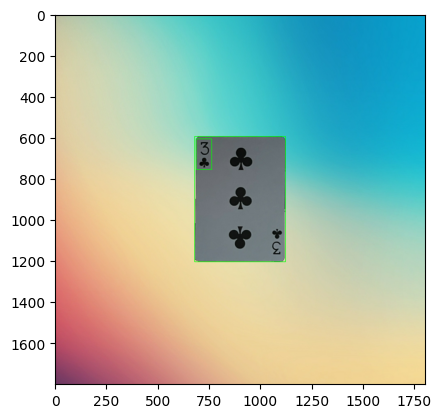

In [85]:
bbox = y_pred['boxes'][0][0]  * scaler_1
# Convert to integers
center_x, center_y, w, h = map(int, bbox)
# Convert center-xywh to top-left x,y
top_left_x = center_x - (w // 2)
top_left_y = center_y - (h // 2)
# Draw the prediction rectangle on the image
cv2.rectangle(decoded_img_opencv_image, (top_left_x, top_left_y), (top_left_x + w, top_left_y + h), (0, 255, 0), 2)
# Draw the inserted cards image rectangle borders
cv2.rectangle(decoded_img_opencv_image, (x_offset, y_offset), (x_offset + w_orig*2, y_offset + h_orig*2), (0, 255, 0), 2)
print(top_left_x)
plt.imshow(decoded_img_opencv_image)

In [86]:
# Coordinate of box inside of card
x_mask, y_mask = (max(0,x_offset - top_left_x),max(0,y_offset-top_left_y)) 
w_mask, h_mask = w,h

print(f'x_mask:{x_mask}, y_mask {y_mask} w_mask {w_mask} h_mask {h_mask}' )

x_mask:0, y_mask 0 w_mask 76 h_mask 149


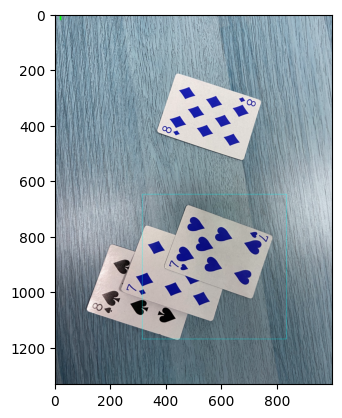

In [69]:
# COORDINATES OF THE BLOCK OF CARDS ARE JUST COORDINATES OF THE CONTAINER
img_test = image.copy()
image_resized = imutils.resize(img_test, width=1000)
test_resize = image_resized.copy()
image_greyscale = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
image_blurred = cv2.GaussianBlur(image_greyscale, (5, 5), 0)
image_canny_kernel = cv2.Canny(image_blurred, 50, 150)
contours, _ = cv2.findContours(image_canny_kernel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

modified_bgs = []
contour = contours[1]
for contour in contours:
    mask = np.zeros_like(image_resized)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
    contour_content = cv2.bitwise_and(image_resized, mask)

    # Create bounding box from contour to crop the alpha mask
x, y, w, h = cv2.boundingRect(contour)
cv2.rectangle(image_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(image_resized)

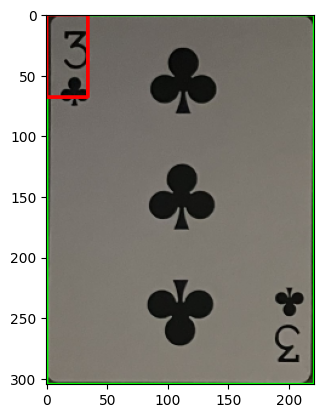

In [88]:
#ONLY NEEDED FOR THE VIZUALIZATION OF BOX INSIDE OF CARDS

frame_cropped = image_resized[y : y + h, x : x + w]
# Coordindates of card class inside of the box
cv2.rectangle(frame_cropped, (x_mask, y_mask), (x_mask + (w_pred*2), y_mask + (h_pred*2)), (255, 0, 0), 2)
plt.imshow(frame_cropped)

In [91]:
print(x,y)
x_small_box


146 202


146

Small Box Coor 146 202 34 68


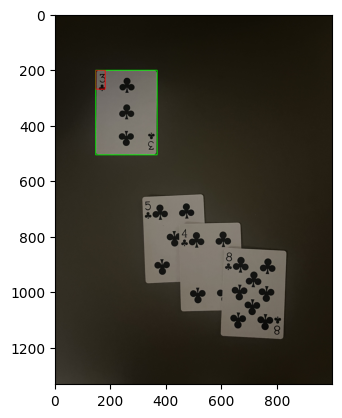

In [89]:
# Coordinates of small box on resized image are
x_small_box, y_small_box = x + x_mask, y+y_mask
width_small_box, height_small_box = x_mask + (w_pred*2), y_mask + (h_pred*2)
plt.imshow(image_resized)
print('Small Box Coor', x_small_box, y_small_box,width_small_box, height_small_box)

In [72]:


# Old image shape (height, width, channels)
old_shape = img_test.shape

# New image shape (height, width, channels)
new_shape = image_resized.shape

# New coordinates of the box (x, y)
new_coordinates = (x_small_box, y_small_box)

# Calculate the old coordinates
coef_x, coef_y = calculate_new_coordinates(old_shape, new_shape)
old_coordinates = int(new_coordinates[0] *coef_x), int(new_coordinates[1]*coef_y)
old_coordinates

(441, 611)

In [79]:
old_x, old_y = old_coordinates
old_width = int(old_x+width_small_box*coef_x)
old_height = int(old_y+height_small_box*coef_y)

print('Old coor',old_x,old_y,old_width,old_height)

Old coor 441 611 543 816


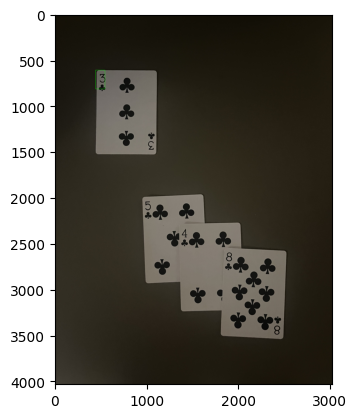

In [74]:
cv2.rectangle(img_test, (old_x, old_y ), (old_width, old_height), (0, 255, 0), 2)
plt.imshow(img_test)

In [45]:
old_x

462

In [136]:
x_coef, y_coef = calculate_new_coordinates(test_resize.shape, example[1].shape)

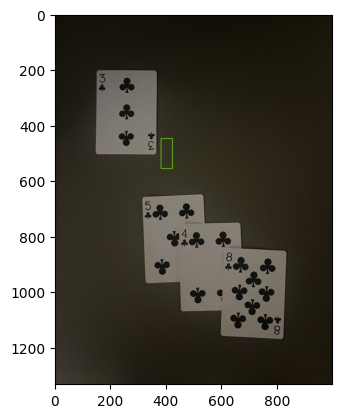

In [138]:
cv2.rectangle(image, (int(x_pr*x_coef), int(y_pr*y_coef) ), (int(w_pr*x_coef), int(h_pr*y_coef)), (100, 200, 10), 2)
plt.imshow(image)

Old coordinates of the box are (442, 611)
